In [23]:
import numpy as np
import matplotlib.pyplot as plt
from parse import parse
import cv2
import time

In [24]:
train_images, train_labels = parse('digitdata/trainingimages', 'digitdata/traininglabels', True)
validation_images, validation_labels = parse('digitdata/validationimages', 'digitdata/validationlabels', True)
test_images, test_labels = parse('digitdata/testimages', 'digitdata/testlabels', True)

In [25]:
base_rate_true = np.bincount(train_labels)/train_labels.shape[0]
print(base_rate_true)

[0.0958 0.1126 0.0976 0.0986 0.107  0.0868 0.1002 0.11   0.0924 0.099 ]


In [26]:
kernel = np.ones((3,3))
images = np.swapaxes(np.swapaxes(train_images.astype(np.float64), 0, 2), 0, 1)
dst = np.zeros_like(images)

if images.shape[2] > 512:
    for i in range(int(np.ceil(images.shape[2]/512))):
        dst[:, :, i*512:(i+1)*512] = cv2.filter2D(src = images[:, :, i*512:(i+1)*512], ddepth = -1, kernel = kernel, anchor = (0,0))
else:
    dst= cv2.filter2D(src = images, ddepth = -1, kernel = kernel, anchor = (0,0))

zones = dst[::3,::3,:]
print(zones.shape)
    

    

(9, 9, 5000)


In [27]:
def train_perceptron_numbers(passes, labels, zones):
    tally = 0
    weights = np.zeros((81,10))
    bias = np.zeros(10)
    for k in range(passes):
        for i in range(len(zones[0][0])):            
            b, index = 0, 0
            arr = zones[:,:,i].ravel()
            for j in range(len(weights[0])):
                a = np.dot(weights[:,j],arr) + bias[j]
                if a > b:
                    b = a
                    index = j
            if labels[i] != index:
                weights[:,index] -= arr
                bias[index] -= 1
                weights[:, labels[i]] += arr
                bias[labels[i]] += 1
            elif k == passes-1 and labels[i] == index:
                tally += 1
    accuracy = tally/len(labels)
    return weights, bias, accuracy

   

In [28]:
vimages = np.swapaxes(np.swapaxes(validation_images.astype(np.float64), 0, 2), 0, 1)
vdst = np.zeros_like(vimages)

if vimages.shape[2] > 512:
    for i in range(int(np.ceil(vimages.shape[2]/512))):
        vdst[:, :, i*512:(i+1)*512] = cv2.filter2D(src = vimages[:, :, i*512:(i+1)*512], ddepth = -1, kernel = kernel, anchor = (0,0))
else:
    vdst= cv2.filter2D(src = vimages, ddepth = -1, kernel = kernel, anchor = (0,0))

vzones = vdst[::3,::3,:]

timages = np.swapaxes(np.swapaxes(test_images.astype(np.float64), 0, 2), 0, 1)
tdst = np.zeros_like(timages)

if timages.shape[2] > 512:
    for i in range(int(np.ceil(timages.shape[2]/512))):
        tdst[:, :, i*512:(i+1)*512] = cv2.filter2D(src = timages[:, :, i*512:(i+1)*512], ddepth = -1, kernel = kernel, anchor = (0,0))
else:
    tdst= cv2.filter2D(src = timages, ddepth = -1, kernel = kernel, anchor = (0,0))

tzones = tdst[::3,::3,:]
print(tzones.shape)


(9, 9, 1000)


In [29]:
def run_perceptron_numbers(weights, labels, zones, bias):
    tally = 0
    for i in range(len(zones[0][0])):
        b, index = 0, 0
        arr = zones[:,:,i].ravel()
        for j in range(len(weights[0])):
            a = np.dot(weights[:,j],arr) + bias[j]
            if a > b:
                b = a
                index = j
        if labels[i] == index:
            tally += 1

    return(tally/len(zones[0][0]))


In [30]:
w, b, c = train_perceptron_numbers(100, train_labels, zones)

run_perceptron_numbers(w, validation_labels, vzones, b)


0.852

In [31]:
def run_percentage(zones, labels, tzones, tlabels, iters):
    mean_acc = np.zeros(10)
    std = np.zeros(10)
    mean_runtime = np.zeros(10)
    training_acc = np.zeros(10)
    training_std = np.zeros(10)
    for i in range(1,11):
        accuracy = np.zeros(iters, dtype=np.float64)
        runtime = np.zeros(iters, dtype=np.float64)
        t_acc = np.zeros(iters, dtype=np.float64)
        for j in range(iters):
            start_time = time.time()
            amount = int(0.1 * i * len(zones[0][0]))
            available_indices = np.random.choice(len(zones[0][0]), amount, replace = False)
            available_zones = zones[:,:,available_indices]
            available_labels= labels[available_indices]
            w, b, t_acc[j-1] = train_perceptron_numbers(100, available_labels, available_zones)         
            accuracy[j-1] = run_perceptron_numbers(w, tlabels, tzones, b)
            runtime[j-1] = time.time()-start_time
        mean_acc[i-1] = np.mean(accuracy)
        std[i-1] = np.std(accuracy)
        mean_runtime[i-1] = np.mean(runtime)
        training_acc[i-1] = np.mean(t_acc)
        training_std[i-1] = np.std(t_acc)
    return mean_acc, std, mean_runtime, training_acc, training_std

[0.758125 0.76125  0.7825   0.788375 0.801625 0.805625 0.801    0.80525
 0.811875 0.818375] [0.01835373 0.01658124 0.01085127 0.01749241 0.01495775 0.01843867
 0.01819341 0.02075301 0.01423409 0.01371074] [0.79610479 1.50918916 2.24263176 2.98890427 3.72595412 4.48296076
 5.22423172 6.17885947 7.00252262 7.87836742] [0.999      0.947      0.92441667 0.9121875  0.89795    0.89591667
 0.89007143 0.88596875 0.88163889 0.879725  ]


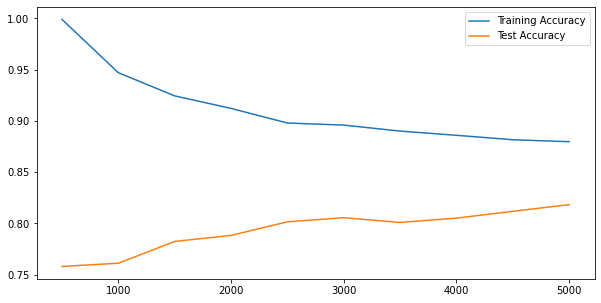

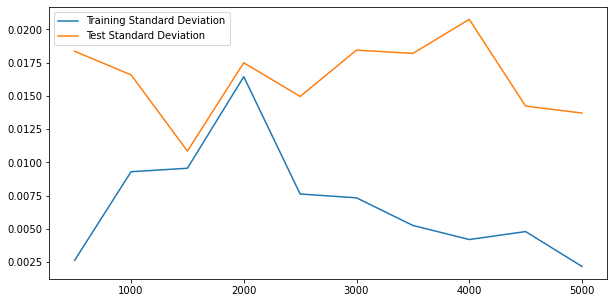

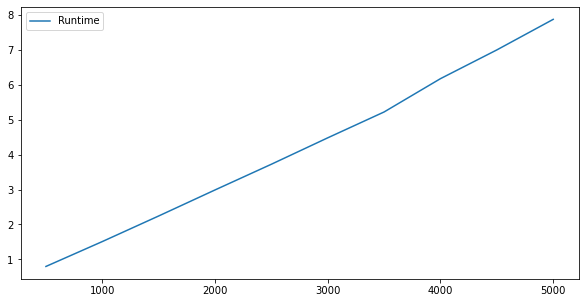

In [32]:
x = np.linspace(.1*train_images.shape[0], train_images.shape[0], 10)
acc, std, runtime, t_acc, t_std = run_percentage(zones, train_labels, tzones, test_labels, 8)
print(acc, std, runtime,t_acc)
plt.figure(0, figsize = (10, 5))
plt.plot(x, t_acc[:], label = "Training Accuracy")
plt.plot(x, acc[:], label = "Test Accuracy")
plt.legend()
plt.figure(1, figsize = (10, 5))
plt.plot(x, t_std[:], label = "Training Standard Deviation")
plt.plot(x, std[:], label = "Test Standard Deviation")
plt.legend()
plt.figure(2, figsize = (10,5))
plt.plot(x, runtime[:], label = "Runtime")
plt.legend()

In [33]:
def run_set_amount(images,zones, labels, weights, bias , num_pictures, random):
    if random == True:
        available_indices = np.random.choice(len(zones[0][0]), num_pictures, replace = False)
        available_zones = zones[:,:,available_indices]
        available_labels= labels[available_indices]
        for i in range(num_pictures):
            b, index = 0, 0
            arr = available_zones[:,:,i].ravel()
            for j in range(len(weights[0])):
                a = np.dot(weights[:,j],arr) + bias[j]
                if a > b:
                    b = a
                    index = j
            print(f"Predicted: {index} | Truth: {available_labels[i]}")
            plt.imshow(images[available_indices[i],:,:])
            plt.show()
            
           
            
    else:
        available_zones = zones[:,:,0:num_pictures]
        available_labels= labels[0:num_pictures]
        for i in range(num_pictures):
            b, index = 0, 0
            arr = available_zones[:,:,i].ravel()
            for j in range(len(weights[0])):
                a = np.dot(weights[:,j],arr) + bias[j]
                if a > b:
                    b = a
                    index = j
            print(f"Predicted: {index} | Truth: {available_labels[i]}")
            plt.imshow(images[i,:,:])
            plt.show()

Predicted: 2 | Truth: 2


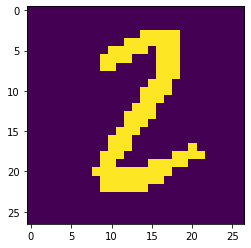

Predicted: 5 | Truth: 3


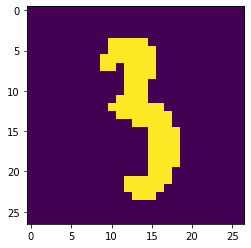

Predicted: 1 | Truth: 1


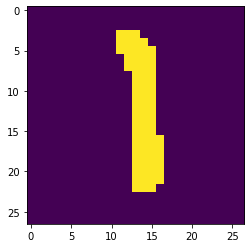

Predicted: 1 | Truth: 1


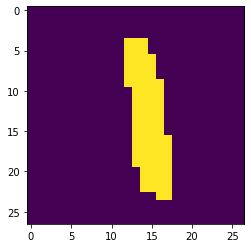

Predicted: 9 | Truth: 4


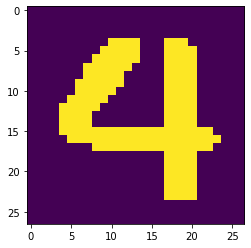

Predicted: 4 | Truth: 4


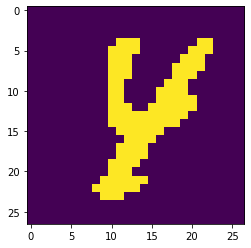

Predicted: 4 | Truth: 9


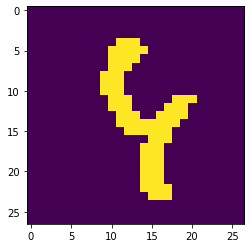

Predicted: 6 | Truth: 6


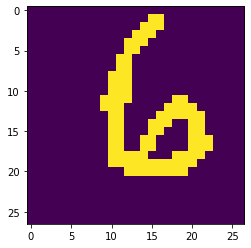

Predicted: 8 | Truth: 8


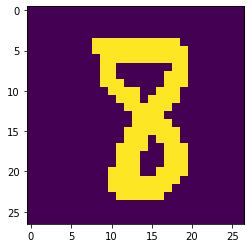

Predicted: 6 | Truth: 6


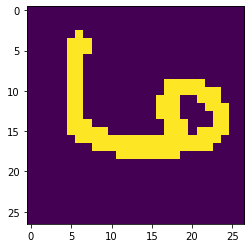

Predicted: 0 | Truth: 0


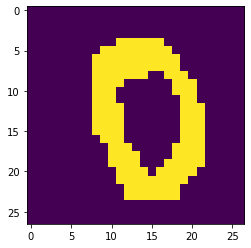

Predicted: 1 | Truth: 1


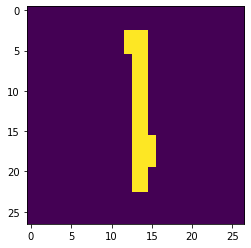

Predicted: 8 | Truth: 8


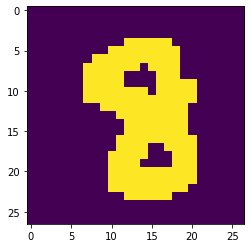

Predicted: 2 | Truth: 6


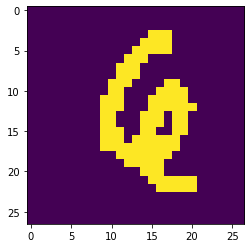

Predicted: 6 | Truth: 6


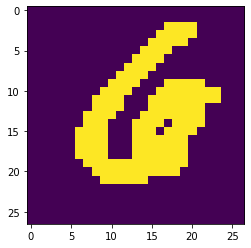

Predicted: 6 | Truth: 6


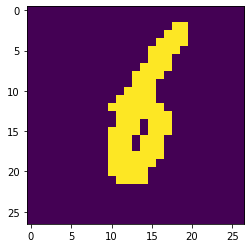

Predicted: 4 | Truth: 4


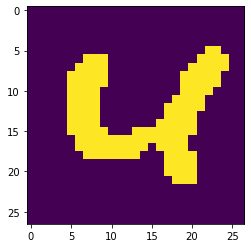

Predicted: 5 | Truth: 5


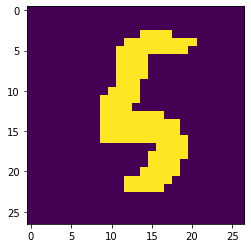

Predicted: 5 | Truth: 5


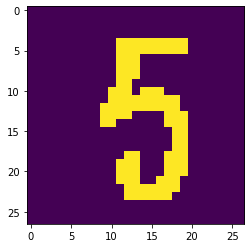

Predicted: 5 | Truth: 5


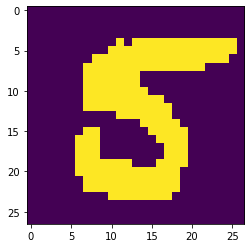

In [34]:
weights, bias, c = train_perceptron_numbers(200, train_labels, zones)

run_set_amount(test_images,tzones, test_labels, weights, bias, 20, True)